In [82]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def mse(y_actual, y_pred):
    assert y_actual.shape == y_pred.shape, "Actual and prediction shapes mismatch"

    return (np.linalg.norm(y_pred - y_actual, axis=1)**2).mean()

def lotka_volterra(t, ys, alpha, beta, delta, gamma):
    x, y = ys
    dx_dt = alpha*x - beta*x*y
    dy_dt = delta*x*y - gamma*y
    
    return dx_dt, dy_dt

In [70]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [71]:
df = pd.read_csv("data/predator-prey-data.csv")
x = np.array(df["t"])
y = np.array(df[["x", "y"]])

In [102]:
from scipy.integrate import solve_ivp

init = y[0]
params = [3, 1, 2, 2]
sol = solve_ivp(lotka_volterra, (x[0], x[-1]), init, args=params, dense_output=True)
z = sol.sol(np.linspace(x[0], x[-1], 100))

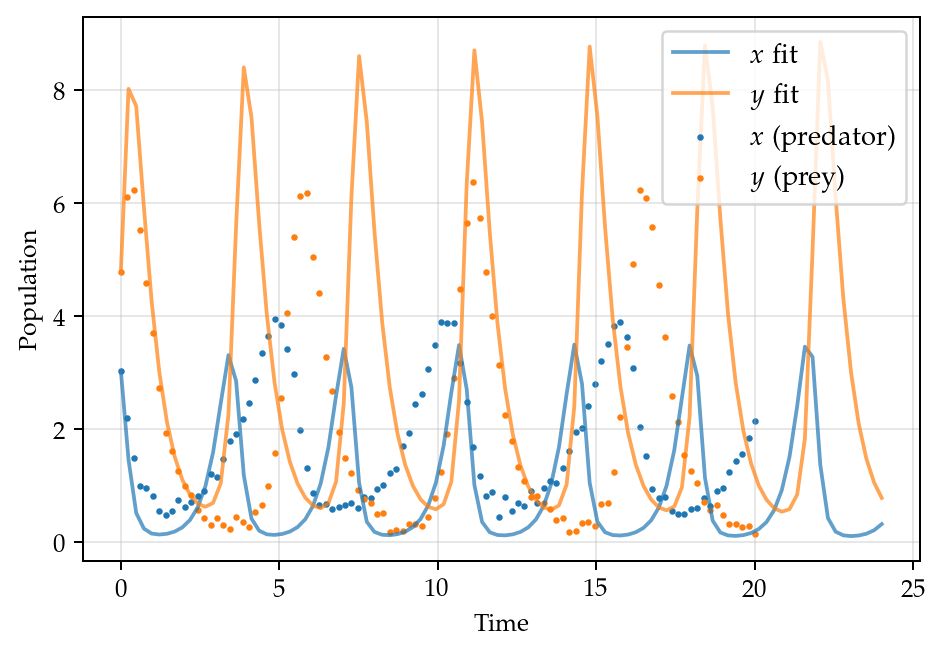

In [103]:
import matplotlib.pyplot as plt

plt.plot(ts, z[0], label="$x$ fit", alpha=0.7)
plt.plot(ts, z[1], label="$y$ fit", alpha=0.7)
plt.scatter(x, y[:,0], s=2.5, label="$x$ (predator)")
plt.scatter(x, y[:,1], s=2.5, label="$y$ (prey)")
plt.ylabel("Population")
plt.xlabel("Time")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [108]:
def int_cost_lotka_volterra(x, y_actual, ts):
    sol = solve_ivp(lotka_volterra, (ts[0], ts[-1]), y[0], args=x, dense_output=True)
    z = sol.sol(ts)
    
    return mse(y_actual, z.T)

x0 = [1, 1, 0.2, 1] # good guess
#x0 = [1, 1, 1, 1] # bad guess
res = minimize(int_cost_lotka_volterra, x0, method="nelder-mead", args=(y, x),
               options={"xatol": 1e-8, "disp": True})
res

 final_simplex: (array([[0.91135123, 0.46100852, 1.09060563, 1.90034394],
       [0.91135105, 0.46101018, 1.09057271, 1.90032051],
       [0.91135856, 0.4610131 , 1.09059436, 1.90033209],
       [0.91134687, 0.46100599, 1.09061835, 1.90035719],
       [0.91133194, 0.46100094, 1.09057832, 1.90033968]]), array([0.02036864, 0.02036876, 0.02036922, 0.02036942, 0.0203701 ]))
           fun: 0.02036863968117465
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 800
           nit: 462
        status: 1
       success: False
             x: array([0.91135123, 0.46100852, 1.09060563, 1.90034394])

0.010184319840587324
0.010184319840587326


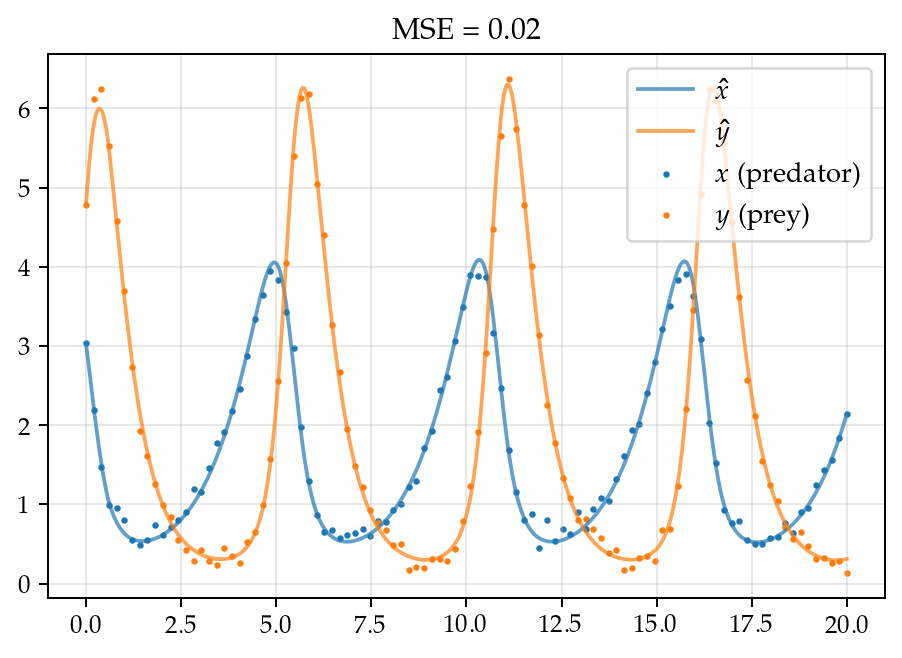

In [109]:
sol_opt = solve_ivp(lotka_volterra, (x[0], x[-1]), init, args=res.x, dense_output=True)
z_opt = sol_opt.sol(x)
ts = np.linspace(x[0], x[-1], 500)
z_opt_smooth = sol_opt.sol(ts)

mse_ = mse(y, z_opt.T)
print(1/2*mse_)
print(mean_squared_error(y, z_opt.T))

plt.plot(ts, z_opt_smooth[0], label="$\\hat{x}$", alpha=0.7)
plt.plot(ts, z_opt_smooth[1], label="$\\hat{y}$", alpha=0.7)
plt.scatter(x, y[:,0], s=2.5, label="$x$ (predator)")
plt.scatter(x, y[:,1], s=2.5, label="$y$ (prey)")
plt.title(f"MSE = ${mse_:.2f}$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()